In [1]:
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [30]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
#from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
#from keras.utils import np_utils
from skimage.transform import resize 
import pandas  # for resizing images
import sklearn
from sklearn.metrics import (mean_squared_error, r2_score)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
#from tensorflow.keras.datasets import mnist         # библиотека базы выборок Mnist
#from tensorflow import keras
#from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

Скачать видео можно здесь: https://drive.google.com/drive/folders/1lzqlMsURXZdsTj5g0agS74o2RSOjUM0H?usp=sharing

In [173]:
def get_frames(name,frame_rate=1/2):#Возвращает список кадров видео
    frames=[]
    cap = cv2.VideoCapture(name)
    frameRate = cap.get(5)*frame_rate #frame rate
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            frames.append(frame)

    cap.release()
    print (f"Done with {name}! count = {len(frames)}")
    return frames

In [4]:
part1 = get_frames('видео по 1 шаблону пульс 90-80.MOV')
part2 = get_frames('спокойное дыхание пульс 90.MOV')
part3 = get_frames('видео по 4 шаблону пульс 154.MOV')
part4 = get_frames('пульс 90-80 видео по 2 шаблону.MOV')
part5 = get_frames('пульс 116-90.MOV')
part6 = get_frames('пульс 142-108 3-4 шаблон.MOV')
part7 = get_frames('пульс 160-150 4 шаблон.MOV')

Done with видео по 1 шаблону пульс 90-80.MOV! count = 133
Done with спокойное дыхание пульс 90.MOV! count = 148
Done with видео по 4 шаблону пульс 154.MOV! count = 106
Done with пульс 90-80 видео по 2 шаблону.MOV! count = 135
Done with пульс 116-90.MOV! count = 139
Done with пульс 142-108 3-4 шаблон.MOV! count = 101
Done with пульс 160-150 4 шаблон.MOV! count = 114


In [5]:
def get_photos_of_body(frames,index_of_deleted,name):#Возвращает обрезанные фотографии
    index=[]
    k=-1
    photos_of_body = [] 
    for img in frames:
        k=k+1
        
        face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
        faces = face_cascade.detectMultiScale(gray, 1.7, 5)#ищет лица
        if len(faces) != 1:#если лица не найдены или их больше 1, то запишем в index номер этого кадра
            index.append(k)
            continue
        for x, y, width, height in faces:
            up_scale = 1.5
            down_scale=9
            yx_scale=2  
            #обрежем часть изображения вокруг лица
            body = img[int((2-up_scale)*y):int(height+y*down_scale),:]#высота изображения
           
            new_width=int(len(body)/yx_scale)
            new_x=int(x+width/2-new_width/2)
            body=body[:,new_x:new_x+new_width]#длина изображения равна 1/2 от высоты
            
            gray = cv2.cvtColor(body, cv2.COLOR_BGR2GRAY)#переводим цветное фото в черно-белое
        photos_of_body.append(gray)
    index_of_deleted[name]=index
    return photos_of_body,index_of_deleted

In [6]:
index_of_deleted={}#кадры, на которых не найдены лица
body1,index_of_deleted=get_photos_of_body(part1,index_of_deleted,'1')
body2,index_of_deleted=get_photos_of_body(part2,index_of_deleted,'2')
body3,index_of_deleted=get_photos_of_body(part3,index_of_deleted,'3')
body4,index_of_deleted=get_photos_of_body(part4,index_of_deleted,'4')
body5,index_of_deleted=get_photos_of_body(part5,index_of_deleted,'5')
body6,index_of_deleted=get_photos_of_body(part6,index_of_deleted,'6')
body7,index_of_deleted=get_photos_of_body(part7,index_of_deleted,'7')
print(index_of_deleted)

{'1': [], '2': [0, 1, 2, 5, 6, 7, 9, 10, 11, 13, 29, 30, 31], '3': [7, 8, 9, 16, 23, 83, 96], '4': [], '5': [30], '6': [1, 11, 36, 64, 83, 85], '7': [2, 113]}


In [7]:
len(body1[1]),len(body1[1][0])

(506, 253)

In [8]:
def make_timeline(bodys,index_of_deleted,name):#добавляет к фото кадры предыдущих 4 секунд
    resized=[]
    resized_copy=[]
    timeline=[]
    index=[]
    k2=0
    
    #приводим все фото к одному размеру
    for img in bodys:
        resized.append(cv2.resize(img, (540, 270), cv2.INTER_LINEAR))
    resized_copy=resized
    
    index.extend([k2+i for i in range(5)])
    k2=k2+5
    
    for i in range(5,len(resized)):
        k2=k2+1
        df=pd.DataFrame(resized[i])
        for k in range(1,5):
            new_df=pd.DataFrame(resized_copy[(i-k)])#пририсовываем к изображению 4 предыдущих изображения
            df=pd.concat([df,new_df],sort=False,axis=1)
        timeline.append(df)
    index_of_deleted[name]=index    
    
    return timeline,index_of_deleted

In [9]:
index_of_deleted2={}

timeline1,index_of_deleted2=make_timeline(body1,index_of_deleted2,'1')
timeline2,index_of_deleted2=make_timeline(body2,index_of_deleted2,'2')
timeline3,index_of_deleted2=make_timeline(body3,index_of_deleted2,'3')
timeline4,index_of_deleted2=make_timeline(body4,index_of_deleted2,'4')
timeline5,index_of_deleted2=make_timeline(body5,index_of_deleted2,'5')
timeline6,index_of_deleted2=make_timeline(body6,index_of_deleted2,'6')
timeline7,index_of_deleted2=make_timeline(body7,index_of_deleted2,'7')


In [10]:
index_of_deleted2

{'1': [0, 1, 2, 3, 4],
 '2': [0, 1, 2, 3, 4],
 '3': [0, 1, 2, 3, 4],
 '4': [0, 1, 2, 3, 4],
 '5': [0, 1, 2, 3, 4],
 '6': [0, 1, 2, 3, 4],
 '7': [0, 1, 2, 3, 4]}

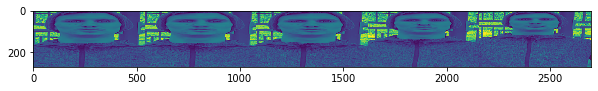

In [11]:
plt.figure(figsize=(10,7))
plt.imshow(timeline1[15])

In [12]:
df1 = pd.read_excel('video_po_1_shabl.xlsx')#размеченные данные с пульсом за секунду
df2 = pd.read_excel('spok_dyh_pyl_90.xlsx')
df3 = pd.read_excel('video_po_4_shabl_puls_154.xlsx')
df4 = pd.read_excel('puls_90-80_video_po_2_shab.xlsx')
df5 = pd.read_excel('puls_116-90.xlsx')
df6 = pd.read_excel('puls_142-108_3-4_shab.xlsx')
df7 = pd.read_excel('puls_160-150_4_shab.xlsx')

y1 = df1.iloc[:,1].values
y2 = df2.iloc[:,1].values
y3 = df3.iloc[:,1].values
y4 = df4.iloc[:,1].values
y5 = df5.iloc[:,1].values
y6 = df6.iloc[:,1].values
y7 = df7.iloc[:,1].values

In [14]:
ys=[y1,y2,y3,y4,y5,y6,y7]
for i in range(len(ys)):
    #дублируем каждое значение Y, что увеличить Y до размера X
    new_y=pd.Series(np.zeros(len(ys[i])*2))
    new_y[new_y.index%2==0]=ys[i][np.int64(np.floor(new_y.index/2))]
    new_y[new_y.index%2==1]=ys[i][np.int64(np.floor(new_y.index/2))]
    ys[i]=new_y

In [15]:
timelines= [timeline1,timeline2,timeline3,timeline4,timeline5,timeline6,timeline7]
for i in range(7):
    #удалим из разметки данные о кадрах, в которых не были найдены лица
    y_index=np.delete(ys[i].index, index_of_deleted[str(i+1)])
    y_index=np.delete(y_index, index_of_deleted2[str(i+1)])
    y=ys[i][y_index]
    
    #если по какой-то причине размерности x и y разные, обрезаем одно из них
    print(i+1,len(y),len(timelines[i]))
    if len(y)<len(timelines[i]):
        timelines[i]=timelines[i][:len(y)]
    if len(timelines[i])<len(y):
        y=y[:len(timelines[i])]
    print(i+1,len(y),len(timelines[i]))
    ys[i]=y

1 125 128
1 125 125
2 126 130
2 126 126
3 90 94
3 90 90
4 125 130
4 125 125
5 128 133
5 128 128
6 87 90
6 87 87
7 104 107
7 104 104


D:\qwe\python\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
#переводим изображение в строку в таблице
df=[]
for timeline in timelines:
    for img in timeline:
        df.append(np.array(img).reshape(1,-1).tolist()[0])

In [17]:
len(df),len(df[0])

(785, 729000)

In [18]:
df=pd.DataFrame(np.array(df[:300000]))#таблица не помещалась в переменную

In [19]:
df2=pd.DataFrame(np.array(df[300000:]))

In [20]:
df=pd.concat([df, df2])

In [21]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,728990,728991,728992,728993,728994,728995,728996,728997,728998,728999
0,39,44,51,55,63,75,94,113,120,122,...,54,57,60,67,75,75,75,76,79,80
1,42,45,59,109,150,183,201,200,191,182,...,70,65,61,60,59,59,59,57,54,53
2,167,180,188,178,181,181,174,163,153,143,...,62,64,65,65,63,63,65,67,68,68
3,167,161,150,135,137,149,171,190,204,206,...,50,57,61,63,62,61,63,63,62,62
4,61,65,68,63,66,76,101,123,132,133,...,88,89,88,88,87,86,86,86,86,86


In [22]:
len(df),len(df[0])

(785, 785)

In [23]:
y_all=ys[0]
for y in ys[1:]:
    y_all = np.append(y, y_all, axis=0)

In [25]:
df=df.join(pd.DataFrame(y_all,columns=['target']))

In [26]:
df

,0,1,2,3,4,5,6,7,8,9,...,728991,728992,728993,728994,728995,728996,728997,728998,728999,target
0,39,44,51,55,63,75,94,113,120,122,...,57,60,67,75,75,75,76,79,80,160.0
1,42,45,59,109,150,183,201,200,191,182,...,65,61,60,59,59,59,57,54,53,160.0
2,167,180,188,178,181,181,174,163,153,143,...,64,65,65,63,63,65,67,68,68,160.0
3,167,161,150,135,137,149,171,190,204,206,...,57,61,63,62,61,63,63,62,62,160.0
4,61,65,68,63,66,76,101,123,132,133,...,89,88,88,87,86,86,86,86,86,160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,148,136,126,133,144,145,137,111,100,111,...,121,105,77,70,73,73,77,92,105,88.0
781,141,134,125,117,109,105,111,123,131,139,...,66,59,63,73,71,58,53,51,49,88.0
782,147,141,132,131,135,136,136,137,138,153,...,78,66,64,82,87,85,84,89,96,88.0
783,121,116,137,148,129,103,114,166,152,130,...,71,73,71,65,59,54,46,38,36,87.0


In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.model_selection import train_test_split

X = df.drop(['target'], axis = 1)
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.33, random_state=42)


In [28]:
import matplotlib.pyplot as plt


def show_parameter_selection(train_acc, test_acc, grid, xlabel, ymin=0.8, ymax=1.005):
    #выводит график train_acc, test_acc
    plt.style.use('ggplot')
    %matplotlib inline
    train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(grid, train_acc, alpha=0.5, color='blue', label='train')
    ax.plot(grid, test_acc, alpha=0.5, color='red', label='test')
    ax.set_title("Подбор " + xlabel)
    ax.legend(loc='best')
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel("r2")
    ax.set_xlabel(xlabel)

In [54]:
model = LinearRegression()#переобучение
model.fit(X_train, y_train)
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

1.0
0.869044652888966


# RandomForest

In [60]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=13)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print("Train score for rf:",rf.score(X_train, y_train)) 
print("Test score for rf:",rf.score(X_test, y_test))  
print("MSE for rf:",mean_squared_error(y_test, rf.predict(X_test)))
r2 = r2_score(y_test, rf_predict)
print(f'R^2 = {r2}')
print("Cross_val_score:",cross_val_score(rf, X_train, np.array(y_train).ravel(), cv=4).mean())

Train score for rf: 0.965184530760475
Test score for rf: 0.8162775542338406
MSE for rf: 139.56740576923076
R^2 = 0.8162775542338406
Cross_val_score: 0.680148264122965


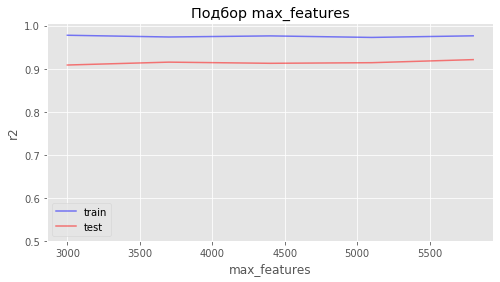

In [61]:
train_acc = []
test_acc = []
max_features_grid = range(3000,6000,700)
for max_features in max_features_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.5)   

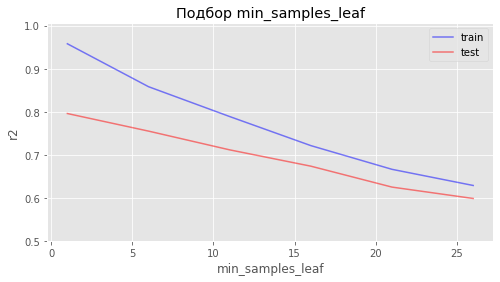

In [34]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(1,31,5)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0.5)   

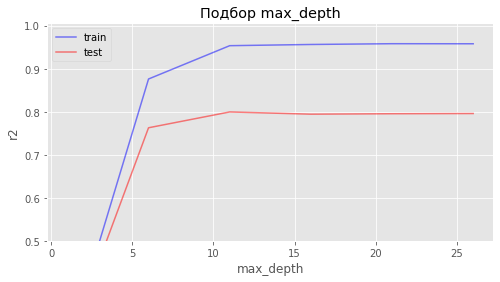

In [35]:
train_acc = []
test_acc = []
max_depth_grid = range(1,31,5)
for max_depth in max_depth_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0.5)   

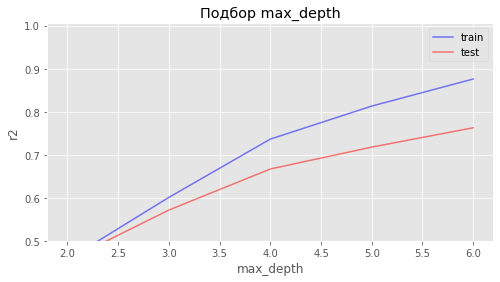

In [39]:
train_acc = []
test_acc = []
max_depth_grid = range(2,7)
for max_depth in max_depth_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0.5)   

Готовая модель

In [47]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=3500,min_samples_leaf=15,max_depth=4)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print("Train score for rf:",rf.score(X_train, y_train)) 
print("Test score for rf:",rf.score(X_test, y_test))  
print("MSE for rf:",mean_squared_error(y_test, rf.predict(X_test)))
r2 = r2_score(y_test, rf_predict)
print(f'R^2 = {r2}')
print("Cross_val_score:",cross_val_score(rf, X_train, np.array(y_train).ravel(), cv=4).mean())

Train score for rf: 0.8912367191339695
Test score for rf: 0.8749416085311631
MSE for rf: 95.00241080610188
R^2 = 0.8749416085311632
Cross_val_score: 0.7650166981554577


# ExtraTrees

In [66]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=40,
                             n_jobs=-1)
xtr.fit(X_train, y_train)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.818955066951374
Score обучающей: 1.0
MSE for DT: 137.53339461538462
[0.72324355 0.70824231 0.70061306 0.69438552]
Avg crossval score: 0.7066211092992423


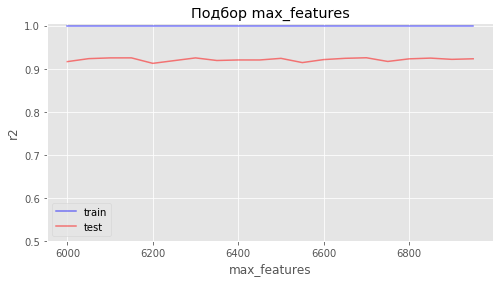

In [67]:
train_acc = []
test_acc = []
max_features_grid = range(6000,7000,50)
for max_features in max_features_grid:
    xtr = ExtraTreesRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1)
    xtr.fit(X_train, y_train)
    train_acc.append(xtr.score(X_train, y_train))
    test_acc.append(xtr.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.5)   

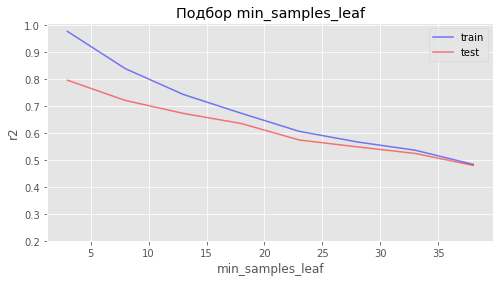

In [68]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(3,40,5)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = ExtraTreesRegressor(n_estimators=50, random_state=42,max_features=48,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0.2)   

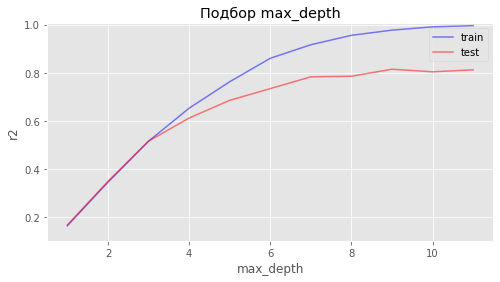

In [69]:
train_acc = []
test_acc = []
max_depth_grid = range(1,12)
for max_depth in max_depth_grid:
    xtr = ExtraTreesRegressor(n_estimators=50, random_state=42,max_depth=max_depth,max_features=50, n_jobs=-1)
    xtr.fit(X_train, y_train)
    train_acc.append(xtr.score(X_train, y_train))
    test_acc.append(xtr.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_depth_grid,"max_depth",ymin=0.1)   

Готовая модель

In [70]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=6500,
                          min_samples_leaf=10,max_depth=5,
                             n_jobs=-1)
xtr.fit(X_train, y_train)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.8927398611230627
Score обучающей: 0.9398966114698947
MSE for DT: 81.48171151909925
[0.82829426 0.77782037 0.77503705 0.78069623]
Avg crossval score: 0.7904619756552718


# KNN

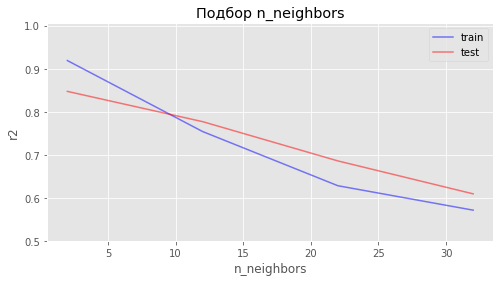

In [37]:
from sklearn.neighbors import KNeighborsRegressor
train_acc = []
test_acc = []
n_neighbors_grid = range(2,40,10)
for n_neighbors in n_neighbors_grid:
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    knn.fit(X_train, y_train)
  
    test_acc.append(r2_score(y_test, knn.predict(X_test)))
    train_acc.append(r2_score(y_train, knn.predict(X_train)))

show_parameter_selection(train_acc, test_acc, n_neighbors_grid,"n_neighbors",ymin=0.5)

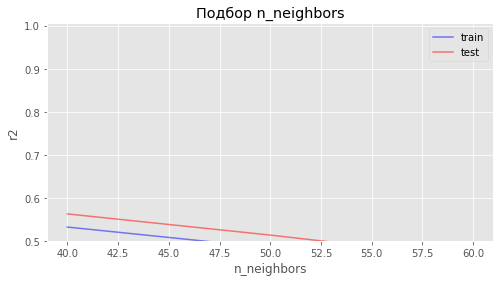

In [44]:
from sklearn.neighbors import KNeighborsRegressor
train_acc = []
test_acc = []
n_neighbors_grid = range(40,70,10)
for n_neighbors in n_neighbors_grid:
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, n_jobs=-1)
    knn.fit(X_train, y_train)
  
    test_acc.append(r2_score(y_test, knn.predict(X_test)))
    train_acc.append(r2_score(y_train, knn.predict(X_train)))

show_parameter_selection(train_acc, test_acc, n_neighbors_grid,"n_neighbors",ymin=0.5)

In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (mean_squared_error, r2_score)
knn=KNeighborsRegressor(n_jobs=-1,n_neighbors=10)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print("Score тестовой:",knn.score(X_test, y_test)) 
print("Score обучающей:",knn.score(X_train, y_train))
print("MSE:",mean_squared_error(y_test, knn.predict(X_test)))
print(cross_val_score(knn, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(knn, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.7981202226185398
Score обучающей: 0.7809636268564104
MSE: 153.36088461538463
[0.72705058 0.63488919 0.63236269 0.65228259]
Avg crossval score: 0.6616462631676842


Лучше всех себя показали ExtraTreesRegressor и RandomForestRegressor

In [49]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)
fold_no = 1
mse=[]
R2_m=[]
print("ExtraTreesRegressor")
for train_index, test_index in skf.split(df, df['target']):
    train = df.loc[train_index,:]
    test = df.loc[test_index,:]
    xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=7000,
                          min_samples_leaf=11,max_depth=10,
                             n_jobs=-1)
    y_train=train['target']
    X_train=train.drop(['target'],axis=1)
    y_test=test['target']
    X_test=test.drop(['target'],axis=1)
    xtr.fit(X_train, y_train)
    print("Fold ",fold_no)
    print(f" Score тестовой:",xtr.score(X_test, y_test))
    print("Score обучающей:",xtr.score(X_train, y_train))
    print("MSE:",mean_squared_error(y_test, xtr.predict(X_test)))
    mse.append(mean_squared_error(y_test, xtr.predict(X_test)))
    R2_m.append(r2_score(y_test, xtr.predict(X_test)))
    fold_no += 1
print()
print("Crossval MSE:",pd.Series(mse).mean())
print("Crossval r2:",pd.Series(R2_m).mean())

ExtraTreesRegressor


D:\qwe\python\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Fold  1
 Score тестовой: 0.7595190937254764
Score обучающей: 0.959734299991634
MSE: 177.99175399635766
Fold  2
 Score тестовой: 0.8190380496114795
Score обучающей: 0.9574880781220906
MSE: 134.00995580748537
Fold  3
 Score тестовой: 0.8495603318289553
Score обучающей: 0.9547121281445151
MSE: 110.77438724285398
Fold  4
 Score тестовой: 0.8419382974546105
Score обучающей: 0.9572421638863139
MSE: 115.72836808651196
Fold  5
 Score тестовой: 0.8400760528661745
Score обучающей: 0.9554390577612026
MSE: 116.5097048264526

Crossval MSE: 131.0028339919323
Crossval r2: 0.8220263650973394


# Проверка

In [83]:
test_frames = get_frames('Видео для теста.MOV')

Done with Видео для теста.MOV! count = 163


In [84]:
index_of_deleted1={}
index_of_deleted2={}
test_bodys,index_of_deleted1=get_photos_of_body(test_frames,index_of_deleted1,'test_frames')
test_timeline,index_of_deleted2=make_timeline(test_bodys,index_of_deleted2,'test_bodys')

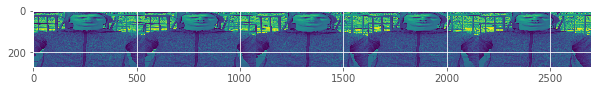

In [86]:
plt.figure(figsize=(10,7))
plt.imshow(test_timeline[10])

In [108]:
pred=[]
for pic in test_timeline:
    pred.append(xtr.predict(np.array(pic).reshape(1,-1))[0])

In [109]:
print(len(pred))

154


In [110]:
for i in index_of_deleted1['test_frames']:
    pred.insert(i, 'Лицо не найдено')
for i in index_of_deleted2['test_bodys']:
    pred.insert(i, 'Подождите...')

In [112]:
pred_df=pd.DataFrame(pred)

In [113]:
pred_df.head(20)

,0
0,Подождите...
1,Подождите...
2,Подождите...
3,Подождите...
4,Подождите...
5,Лицо не найдено
6,94.4812
7,93.1945
8,Лицо не найдено
9,Лицо не найдено


In [174]:
#Попробую предсказать пульс по началу этого видео с вейтлифтером https://www.youtube.com/watch?v=AOYPHjnlbXQ
test_frames = get_frames('weightlifter.mov',frame_rate=1/5)

Done with weightlifter.mov! count = 238


In [175]:
index_of_deleted1={}
index_of_deleted2={}
test_bodys,index_of_deleted1=get_photos_of_body(test_frames,index_of_deleted1,'test_frames')
test_timeline,index_of_deleted2=make_timeline(test_bodys,index_of_deleted2,'test_bodys')

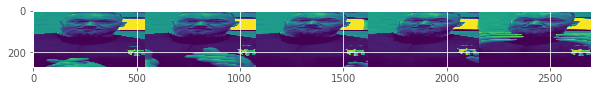

In [176]:
plt.figure(figsize=(10,7))
plt.imshow(test_timeline[10])

In [177]:
pred=[]
for pic in test_timeline:
    pred.append(xtr.predict(np.array(pic).reshape(1,-1))[0])

In [178]:
print(len(pred))#человек на видео слишком часто двигается и не смотрит в камеру

107


In [179]:
for i in index_of_deleted1['test_frames']:
    pred.insert(i, 'Лицо не найдено')
for i in index_of_deleted2['test_bodys']:
    pred.insert(i, 'Подождите...')

In [180]:
pred[3:len(pred)]

['Подождите...',
 'Подождите...',
 107.80923035435495,
 107.64946832716647,
 108.30929248402377,
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 106.5601576038921,
 107.14814243676861,
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 106.90428875252718,
 106.07761088578022,
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 108.5682428722808,
 105.96575044118038,
 106.20101717169787,
 105.62777437858625,
 107.51349116937772,
 105.88524082449199,
 105.46791584404586,
 106.76489842007837,
 108.33836423608209,
 109.4782846439336,
 108.2322365647768,
 104.81988112768724,
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не найдено',
 106.69132191557156,
 'Лицо не найдено',
 'Лицо не найдено',
 108.74854492153872,
 'Лицо не найдено',
 'Лицо не найдено',
 'Лицо не